## Data downloaded and extracted from Mendeley Data

dataset_url: https://data.mendeley.com/datasets/tywbtsjrjv/1

## Installing and importing required libraries 

In [ ]:
import os
if os.name == 'nt':
    !pip install numpy pandas matplotlib seaborn

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb

### checking for availability of GPU

In [72]:
gpus = tf.config.list_physical_devices('GPU')
if gpus: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in gpus]
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


## Data Loading and visualizing

In [3]:
data_dir = 'C:/Users/prash/Data_science/Computer_vision/Projects/Plant_leaves_diseases/Plant_leave_diseases_dataset'

In [4]:
data_dir

'C:/Users/prash/Data_science/Computer_vision/Projects/Plant_leaves_diseases/Plant_leave_diseases_dataset'

In [5]:
len(os.listdir(data_dir))

33

In [6]:
Image_size = 256
Batch_size = 32

In [7]:
data = tf.keras.utils.image_dataset_from_directory(data_dir,shuffle=True,
                                                    image_size=(Image_size,Image_size),
                                                    batch_size=Batch_size)

Found 40000 files belonging to 33 classes.


In [8]:
classes = data.class_names
classes

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [9]:
for image_batch, label_batch in data.take(1) :
    print (image_batch.shape)
    print (label_batch.numpy( ))

(32, 256, 256, 3)
[ 3 29 29 21 10 29 29 32 24 32 30  9 30  9  7 11  1 25 27 25  3 12 30 27
  8 14 27 32 16 30  4 21]


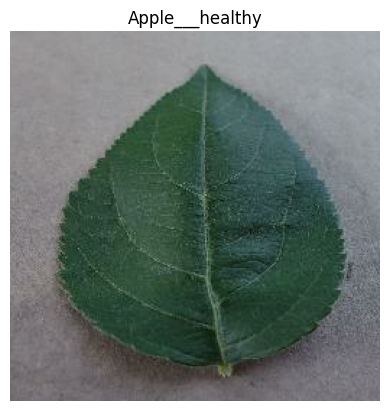

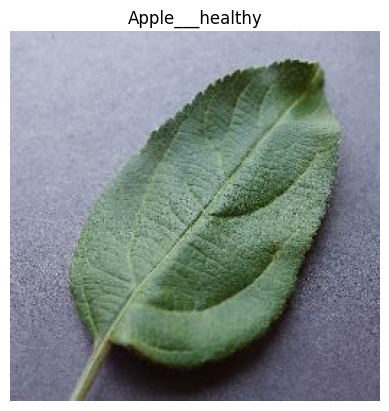

In [10]:
for image_batch, label_batch in data.take(1):
    for x in range(2):
        plt.imshow(image_batch[x].numpy().astype('uint8'))
        plt.title(classes[label_batch[x]])
        plt.axis('off')
        plt.show()

In [11]:
len(data)

1250

## Splitting the data into train validation and test sets

In [12]:
train_ds = data.take(int(len(data)*.7))
validation_ds = data.skip(int(len(data)*.7)).take(int(len(data)*.2))
test_ds = data.skip(int(len(data)*.9)).take(int(len(data)*.1))

In [13]:
len(train_ds),len(validation_ds),len(test_ds)

(875, 250, 125)

In [14]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds= validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Building and training

In [15]:
import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [50]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', input_shape=(256, 256, 3), include_top=False)

base_model.trainable = False

input = keras.Input(shape=(256, 256, 3))
x = base_model(input, training=False)

x = keras.layers.Conv2D(16, (1, 1), activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv2D(32, (1, 1), activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Conv2D(64, (1, 1), activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)

x = keras.layers.Dense(33, activation='softmax')(x)

model = keras.Model(inputs=input, outputs=x)

In [51]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.001
optim = Adam(learning_rate=learning_rate)

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optim, metrics = ['accuracy'])

In [52]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 16)          32784     
                                                                 
 dropout_6 (Dropout)         (None, 8, 8, 16)          0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 32)          544       
                                                                 
 dropout_7 (Dropout)         (None, 8, 8, 32)          0         
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 64)          2112

In [53]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

In [54]:
hist = model.fit(train_ds, epochs=100,batch_size = Batch_size,validation_data=validation_ds, callbacks=[callbacks])

Epoch 1/100
875/875 [==============================] - 204s 230ms/step - loss: 1.1372 - accuracy: 0.6437 - val_loss: 0.5431 - val_accuracy: 0.8294
Epoch 2/100
875/875 [==============================] - 204s 233ms/step - loss: 0.4862 - accuracy: 0.8405 - val_loss: 0.3774 - val_accuracy: 0.8811
Epoch 3/100
875/875 [==============================] - 198s 227ms/step - loss: 0.3572 - accuracy: 0.8851 - val_loss: 0.2593 - val_accuracy: 0.9153
Epoch 4/100
875/875 [==============================] - 196s 224ms/step - loss: 0.2982 - accuracy: 0.9072 - val_loss: 0.2765 - val_accuracy: 0.9144
Epoch 5/100
875/875 [==============================] - 200s 228ms/step - loss: 0.2553 - accuracy: 0.9213 - val_loss: 0.2482 - val_accuracy: 0.9273
Epoch 6/100
875/875 [==============================] - 195s 223ms/step - loss: 0.2240 - accuracy: 0.9320 - val_loss: 0.2085 - val_accuracy: 0.9392
Epoch 7/100
875/875 [==============================] - 209s 239ms/step - loss: 0.2140 - accuracy: 0.9364 - val_loss: 0

## Visualizing accuracy and loss of train and validation datasets

In [55]:
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

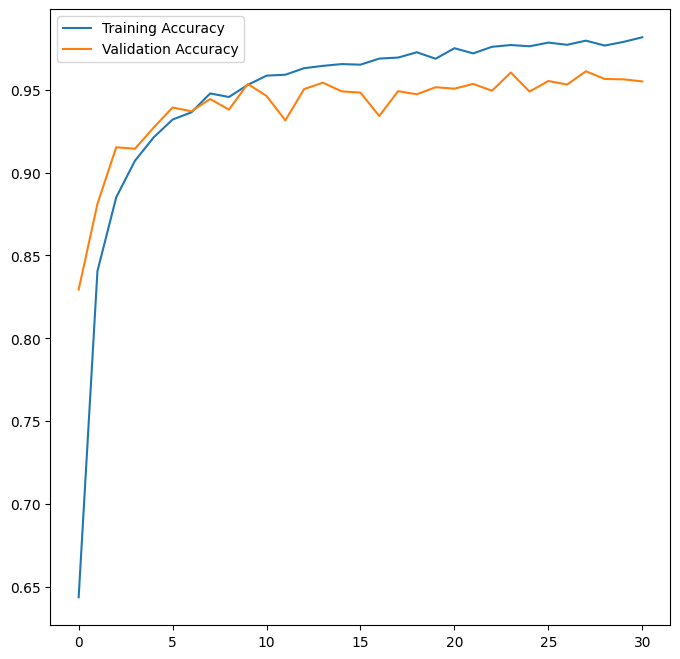

In [56]:
plt.figure(figsize=(8,8))
plt.plot(accuracy,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend(loc="upper left")
plt.show()



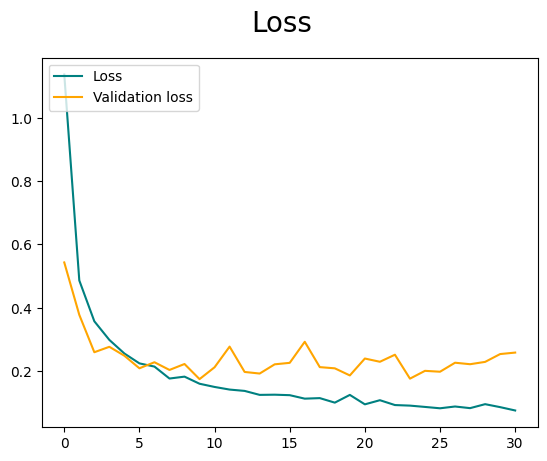

In [57]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Validation loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Predicting on test set

In [58]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [59]:
scores = model.evaluate(test_ds)

125/125 [==============================] - 37s 298ms/step - loss: 0.1957 - accuracy: 0.9538


first image to predict
actual label:  Corn___Common_rust
1/1 [==============================] - 2s 2s/step
predicted label:  Corn___Common_rust


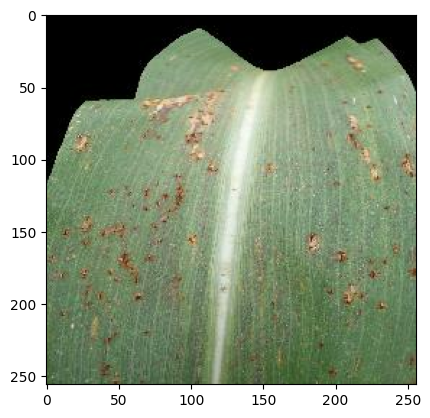

In [60]:
for images_batch,labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label: ',classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print('predicted label: ',classes[np.argmax(batch_prediction[0])])
    

In [61]:
def predict(model, img) :
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0 ) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class= classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class,confidence


1/1 [==============================] - 0s 28ms/step


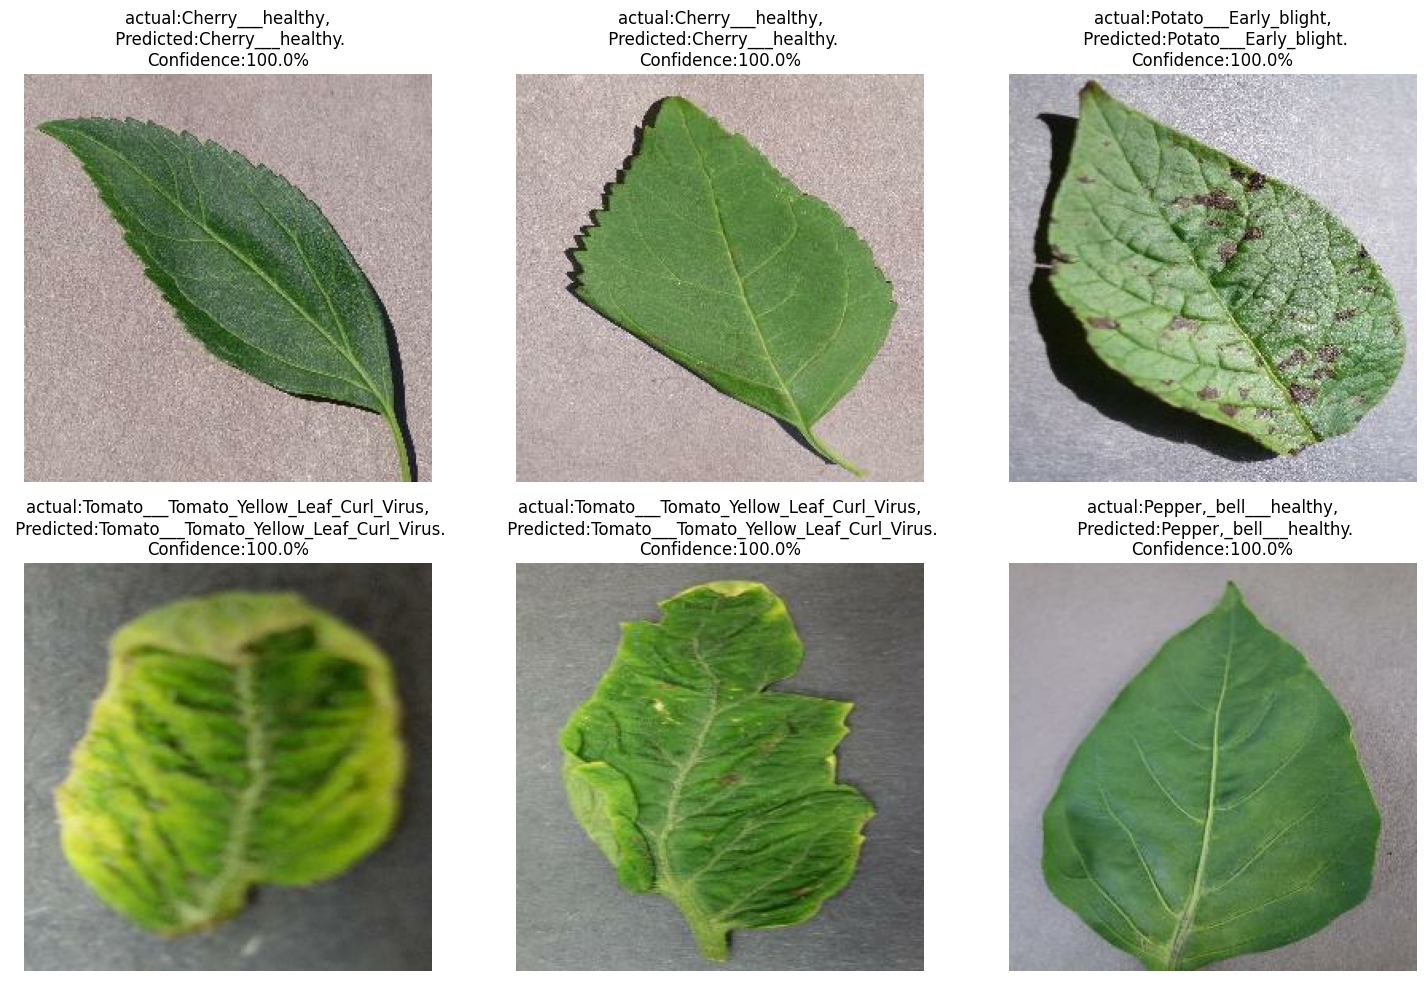

In [63]:
plt.figure(figsize=(18,18))

for images,labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = classes[labels[i]]
        
        plt.title(f'actual:{actual_class},\n Predicted:{predicted_class}.\nConfidence:{confidence}%')
        
        plt.axis('off')

## Saving and predicting using saved model

In [65]:
model.save('plant_leaves_disease_detection_model.h5')

In [66]:
loaded_model = tf.keras.models.load_model('plant_leaves_disease_detection_model.h5')

1/1 [==============================] - 0s 24ms/step


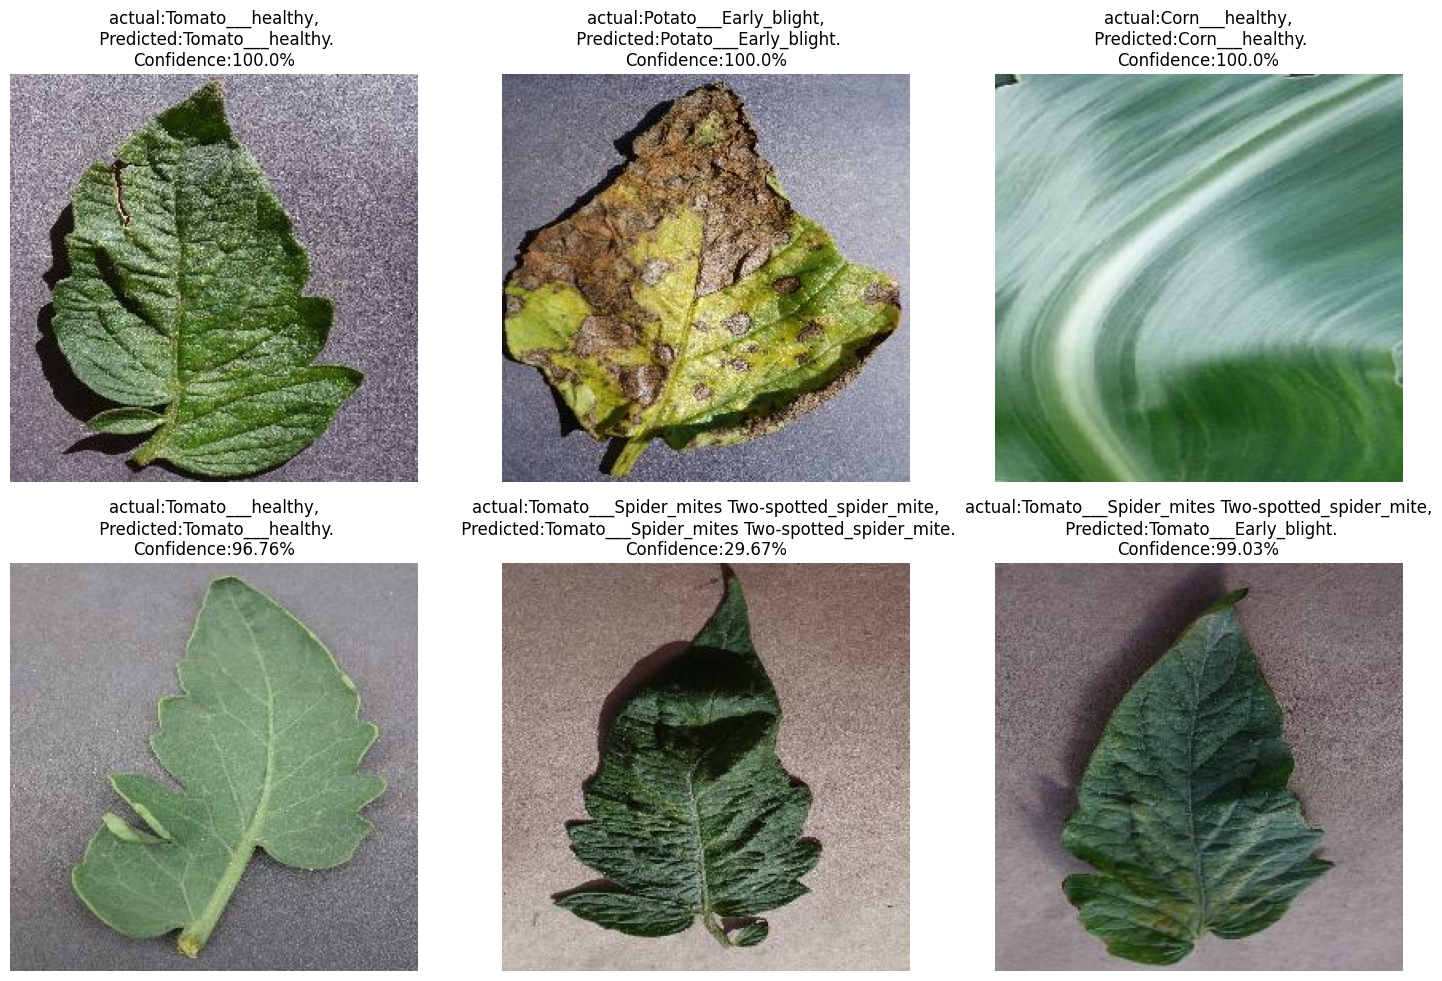

In [67]:
plt.figure(figsize=(18,18))

for images,labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence = predict(loaded_model,images[i].numpy())
        actual_class = classes[labels[i]]
        
        plt.title(f'actual:{actual_class},\n Predicted:{predicted_class}.\nConfidence:{confidence}%')
        
        plt.axis('off')

## Further Improvements

To further improve the model's performance, implementing the Keras ImageDataGenerator or Albumentations library for data augmentation could be beneficial. Moreover, considering deployment options like Tensorflow Lite or Streamlit may be useful in deploying the model in real-time scenarios.